# LAB 4: Topic modeling

Use topic models to explore hotel reviews

Objectives:
* tokenize with MWEs using spacy
* estimate LDA topic models with tomotopy
* visualize and evaluate topic models
* apply topic models to interpretation of hotel reviews

## Build topic model

In [1]:
import pandas as pd
import numpy as np
from cytoolz import *
from tqdm.auto import tqdm
tqdm.pandas()

### Read in hotel review data and tokenize it

In [3]:
df = pd.read_parquet('hotels.parquet')

In [4]:
from tokenizer import MWETokenizer

tokenizer = MWETokenizer(open('hotel-terms.txt'))

Select a sample of reviews to work with (replace x's below with the sample size; you should use at least 50,000 reviews)

In [5]:
subdf = df.sample(50000)

In [6]:
subdf['tokens'] = pd.Series(subdf['text'].progress_apply(tokenizer.tokenize))

  0%|          | 0/50000 [00:00<?, ?it/s]

### Estimate model

In [7]:
import tomotopy as tp
import time

These are the model **hyperparameters**: aspects of the model that aren't estimated from the data but have to be set in advance by the analyst. There's no "right" values for these. You'll just have to try out different values to find settings that give you a model that you can interpret:

* *k* = number of topics
* *min_df* = minimum number of reviews that a term has to occur in to be included in the model
* *rm_top* = number of most frequent terms to remove from the model
* *tw* = term weighting strategy (described [here](https://bab2min.github.io/tomotopy/v0.10.1/en/#tomotopy.TermWeight)]
* *alpha*, *eta* = priors for document-topic and topic-word distributions
* *tol* = convergence tolerance


In [14]:
k = 100
min_df = 100
rm_top = 75
tw = tp.TermWeight.ONE
alpha = 0.1
eta = 0.01
tol = 1e-3

Here's where we do the inference. The documentation for `LDAModel` is [here](https://bab2min.github.io/tomotopy/v0.10.1/en/#tomotopy.LDAModel). You might also consider trying out one of the other model types (e.g., `HDPModel`).

In [15]:
%%time

mdl = tp.LDAModel(k=k, min_df=min_df, rm_top=rm_top, tw=tw, alpha=alpha, eta=eta)

for doc in subdf['tokens']:
    if doc:
        mdl.add_doc(doc)

last = np.NINF
for i in range(0, 5000, 50):
    mdl.train(50)
    ll = mdl.ll_per_word
    print(f'{i:5d} LL = {ll:7.4f}', flush=True)
    if ll - last < tol:
        break
    else:
        last = ll

print(f'Done!')

    0 LL = -8.8938
   50 LL = -8.6816
  100 LL = -8.6058
  150 LL = -8.5600
  200 LL = -8.5281
  250 LL = -8.5093
  300 LL = -8.4928
  350 LL = -8.4814
  400 LL = -8.4756
  450 LL = -8.4702
  500 LL = -8.4650
  550 LL = -8.4630
  600 LL = -8.4596
  650 LL = -8.4543
  700 LL = -8.4570
Done!
CPU times: user 15min 22s, sys: 7.53 s, total: 15min 29s
Wall time: 5min 4s


### Evaluate the model

What terms are associated with each topic?

In [16]:
for k in range(mdl.k):
    print(f'{k:3d} ', ', '.join(s for s,_ in mdl.get_topic_words(k)))

  0  club, four, seasons, service, ritz, fairmont, sofitel, concierge, philadelphia, quarters
  1  made, feel, make, their, every, home, way, always, who, went
  2  she, said, told, her, asked, manager, back, then, called, front_desk
  3  new, been, renovated, has, recently, newly, property, renovation, construction, remodeled
  4  your, want, go, back, take, day, time, people, any, some
  5  breakfast, coffee, eggs, fruit, bagels, cereal, juice, muffins, waffles, etc
  6  game, downtown, memphis, denver, stadium, see, walk, baseball, graceland, beale_street
  7  dog, kimpton, pet, dogs, friendly, palomar, hotels, pets, their, traveling
  8  san_diego, beach, bay, view, pool, area, marina, ocean, tower, right
  9  star, 4, 5, stars, star_hotel, 3, give, hotels, four, five
 10  wine, evening, coffee, day, cookies, morning, free, lobby, each, every
 11  check, arrived, early, after, p.m., ready, a.m., until, before, 3
 12  nyc, times_square, subway, central_park, broadway, street, manhat

Which terms got remove due to `rm_top`?

In [17]:
', '.join(mdl.removed_top_words)

"the, and, a, to, was, i, in, we, of, is, for, it, not, hotel, room, at, were, that, but, on, this, with, very, you, had, have, my, there, are, our, they, from, as, so, stay, would, be, all, do, 's, rooms, if, one, staff, stayed, out, great, clean, when, us, which, an, no, nice, just, or, up, here, about, get, good, location, night, could, can, will, also, me, only, $, by, again, well, like, did"

Visualize topic model with LDAvis

In [18]:
import pyLDAvis

topic_term_dists = np.stack([mdl.get_topic_word_dist(k)
                             for k in range(mdl.k)])
doc_topic_dists = np.stack([doc.get_topic_dist() for doc in mdl.docs])
doc_lengths = np.array([len(doc.words) for doc in mdl.docs])
vocab = list(mdl.used_vocabs)
term_frequency = mdl.used_vocab_freq
prepared_data = pyLDAvis.prepare(topic_term_dists,
                                 doc_topic_dists,
                                 doc_lengths,
                                 vocab,
                                 term_frequency, 
                                 mds='tsne', 
                                 sort_topics=False
                                 )

/opt/conda/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


In [19]:
pyLDAvis.display(prepared_data)

Find documents that best represent each topic

In [20]:
for i,d in enumerate(np.argmax(doc_topic_dists, axis=0)):
    print(i, ', '.join(map(first, mdl.get_topic_words(i))))
    print(subdf['text'].iloc[d])
    print()

0 club, four, seasons, service, ritz, fairmont, sofitel, concierge, philadelphia, quarters
Typical Four Seasons. Tops in service, accommodations, food, location. I have stayed here probably 90 times and is always superb.

1 made, feel, make, their, every, home, way, always, who, went
This Hotel is by far one of the finest we have ever stayed in. The Front Desk Host is pleasant and very knowledgeable and very friendly. He makes you feel at home and welcomes you as if you were an honored guest. This is the second time we have stayed here and will do every time we are in Charlotte. The front desk and Walt cannot do enough to make your stay enjoyable.

2 she, said, told, her, asked, manager, back, then, called, front_desk
Please do not go to this hotel. They double-charged me twice. I called the hotel and asked to speak to the manager. She said the manager was out of town and could not be reached. I demanded he be called because this was $500.00 that was taken out of my account. After tell

Generate word clouds for topics

In [21]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

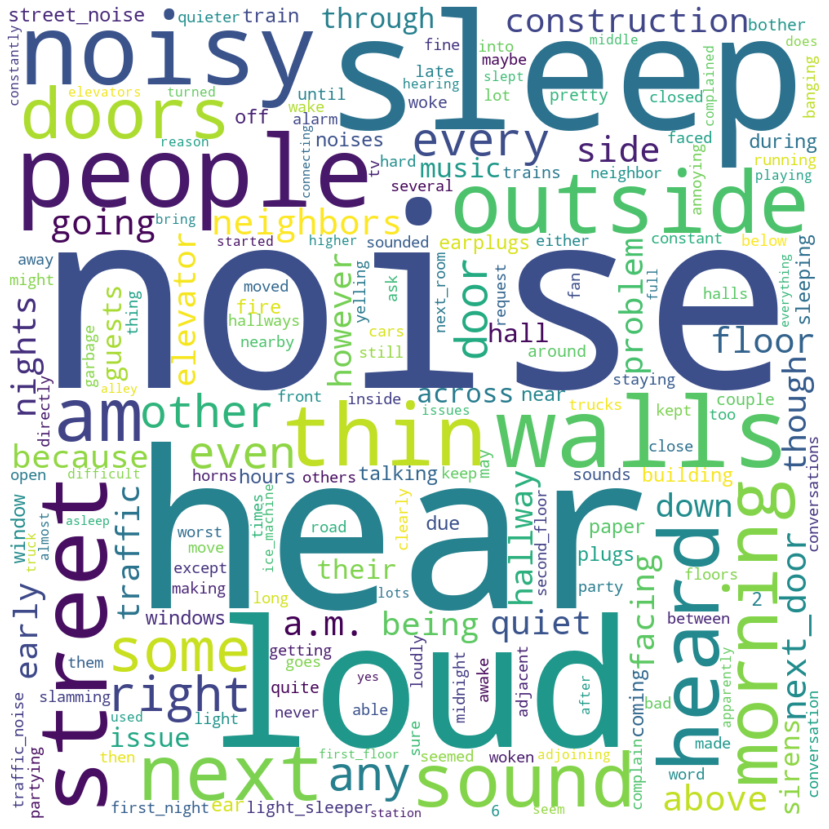

In [22]:
plt.figure(figsize=(15,15))
freqs = dict(mdl.get_topic_words(54, 200))
wc = WordCloud(width=1000,height=1000,background_color='white').generate_from_frequencies(freqs)
plt.axis('off')
plt.imshow(wc, interpolation='bilinear')
plt.show()

### Save the final, best model

In [23]:
mdl.save('hotel-topics.bin')